### Markowitz en Paralelo

In [23]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit, prange

Cargamos el Dataset

In [ ]:
data = pd.read_csv(r"\dataset.csv", index_col ="Date" )

Calculamos las medias, además de la matriz de varianza y covarianza

In [12]:
# Medias
mu = data.mean().values  
# Matriz de covarianza
cov = data.cov()
cov

,SP500_ret,GOLD_ret,NVDA_ret,JPM_ret,MELI_ret,GOOG_ret,JNJ_ret,MTRTX_ret,W_ret
SP500_ret,9.447168e-05,0.000002,-2.167744e-07,-0.000015,0.000005,0.000005,-2.392112e-07,0.000004,0.000003
GOLD_ret,1.847922e-06,0.000298,5.902949e-05,0.000115,0.000224,0.000255,9.952517e-05,0.000057,0.000130
NVDA_ret,-2.167744e-07,0.000059,1.202063e-04,0.000072,0.000065,0.000055,6.821352e-05,0.000050,0.000064
JPM_ret,-1.523977e-05,0.000115,7.223888e-05,0.000269,0.000143,0.000159,1.544382e-04,0.000053,0.000127
MELI_ret,4.526338e-06,0.000224,6.539739e-05,0.000143,0.000861,0.000374,1.269888e-04,0.000068,0.000170
GOOG_ret,5.361628e-06,0.000255,5.496839e-05,0.000159,0.000374,0.000783,1.263603e-04,0.000075,0.000193
JNJ_ret,-2.392112e-07,0.000100,6.821352e-05,0.000154,0.000127,0.000126,2.540244e-04,0.000048,0.000109
MTRTX_ret,4.092328e-06,0.000057,5.046485e-05,0.000053,0.000068,0.000075,4.826171e-05,0.000158,0.000058
W_ret,2.747334e-06,0.000130,6.369191e-05,0.000127,0.000170,0.000193,1.087573e-04,0.000058,0.000114


In [16]:
cov = cov.values


Función que genere las simulaciones Monte Carlo 

In [32]:
@njit(parallel = True)
def simulate_portfolios(mu, cov, n_portfolios):
    n = len(mu)

    # Matrices para guardar resultados
    all_weights = np.zeros((n_portfolios, n))
    returns_p = np.zeros(n_portfolios)
    vol_p = np.zeros(n_portfolios)
    sharpe_p = np.zeros(n_portfolios)

    for i in prange(n_portfolios):
        # pesos aleatorios normalizados
        w = np.random.random(n)
        w = w / np.sum(w)

        # métricas
        ret = np.dot(w, mu)
        vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        sharpe = ret / vol

        # guardar
        all_weights[i] = w
        returns_p[i] = ret
        vol_p[i] = vol
        sharpe_p[i] = sharpe

    return all_weights, returns_p, vol_p, sharpe_p


In [33]:
#Contador de inicio
start_time = time.time()

# Cantidad de sumulaciones 
N = 10000000 
# Pesos, retornos, valatilidad, indice de desempeño calculados
weights, rets, vols, sharpes = simulate_portfolios(mu, cov, N)


end_time = time.time()


elapsed_time = end_time - start_time
print(f"El código tardó: {elapsed_time} segundos")

El código tardó: 1.9599573612213135 segundos


Calculamos el portafolio de mayor desempeño y el de menor riesgo

In [28]:
idx_min_var = np.argmin(vols)
idx_max_sharpe = np.argmax(sharpes)

w_min_var = weights[idx_min_var]
w_max_sharpe = weights[idx_max_sharpe]

tickers = data.columns.tolist()

print("\n--- Portafolio de Mínima Varianza ---")
for t, w in zip(tickers, w_min_var):
    print(f"{t}: {w:.4f}")

print("\n--- Portafolio de Máximo Sharpe ---")
for t, w in zip(tickers, w_max_sharpe):
   print(f"{t}: {w:.4f}")


--- Portafolio de Mínima Varianza ---
SP500_ret: 0.4241
GOLD_ret: 0.0670
NVDA_ret: 0.2692
JPM_ret: 0.0464
MELI_ret: 0.0057
GOOG_ret: 0.0161
JNJ_ret: 0.0368
MTRTX_ret: 0.1277
W_ret: 0.0072

--- Portafolio de Máximo Sharpe ---
SP500_ret: 0.2006
GOLD_ret: 0.0133
NVDA_ret: 0.1935
JPM_ret: 0.1122
MELI_ret: 0.0025
GOOG_ret: 0.2688
JNJ_ret: 0.0008
MTRTX_ret: 0.1959
W_ret: 0.0124


Gráfica de la Frontera eficiente

C:\Users\marco\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


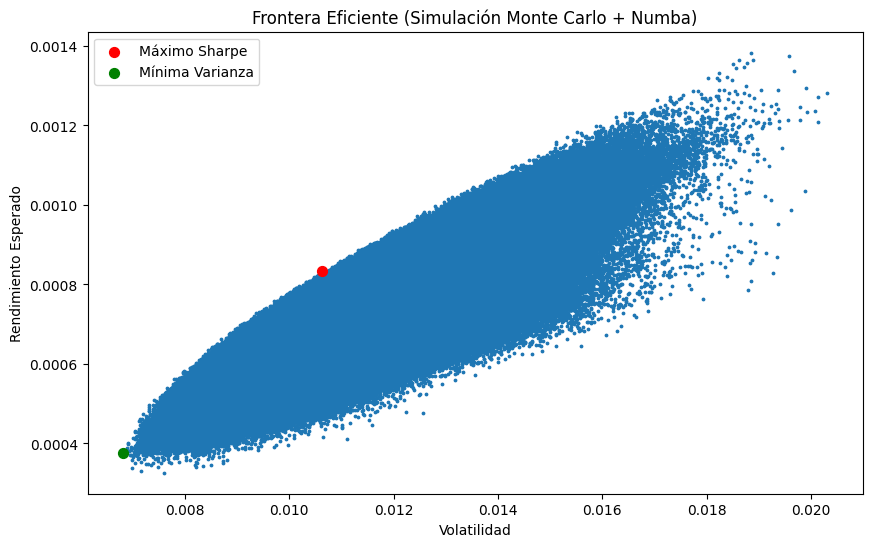

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(vols, rets, s=3)
plt.scatter(vols[idx_max_sharpe], rets[idx_max_sharpe], color="red", s=50, label="Máximo Sharpe")
plt.scatter(vols[idx_min_var], rets[idx_min_var], color="green", s=50, label="Mínima Varianza")
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento Esperado")
plt.title("Frontera Eficiente")
plt.legend()
plt.show()
